In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [2]:
%matplotlib nbagg

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import libertem.api as lt
import libertem.udf.blobfinder as blb
import libertem.analysis.gridmatching as grm
from libertem.executor.inline import InlineJobExecutor

In [5]:
ctx = lt.Context()

In [6]:
ds = ctx.load(
    'ser',
    path=r'C:/Users/weber/Nextcloud/Projects/Open Pixelated STEM framework/Data/NBED-R3/NBED-R3-map_1.ser'
)
(y, x) = ds.shape.nav

In [7]:
zero = np.array((281.88, 276.41))
p1 = np.array((8.62, 273.36))
p2 = np.array((275.19, 487.80))

a = (p1 - zero) / 4
b = (p2 - zero) / 3

grid = np.mgrid[-3:4, -3:4]

indices = np.concatenate(grid.T)

peaks = grm.calc_coords(zero, a, b, indices)

corr_params = dict(
    radius=10.0,
    padding=1,
    mask_type='radial_gradient',
    num_disks=len(peaks)
)
match_params = dict(
    min_delta=min(np.linalg.norm(a), np.linalg.norm(b))*0.7,
    max_delta=max(np.linalg.norm(a), np.linalg.norm(b))*1.4
)

In [8]:
match = blb.run_refine(ctx, ds, zero, a, b, indices, corr_params, match_params)

In [9]:
zeros = match['zero'].data.reshape((y, x, 2))
aas = match['a'].data.reshape((y, x, 2))
bbs = match['b'].data.reshape((y, x, 2))

In [10]:
polar_zeros = grm.make_polar(match['zero'].data).reshape((y, x, 2))
polar_aas = grm.make_polar(match['a'].data).reshape((y, x, 2))
polar_bbs = grm.make_polar(match['b'].data).reshape((y, x, 2))

<IPython.core.display.Javascript object>


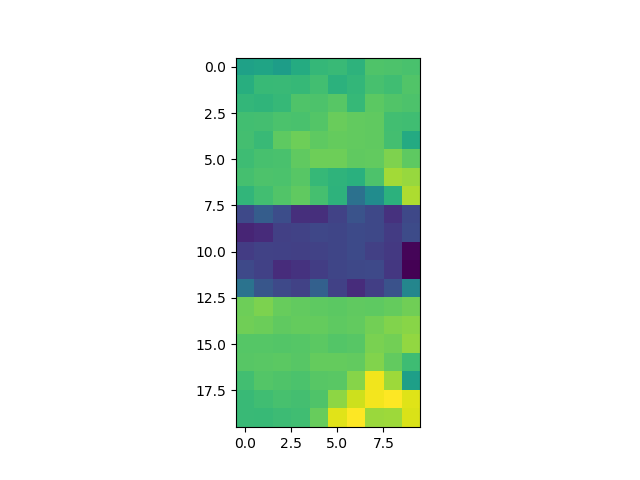

In [11]:
fig, axes = plt.subplots()
axes.imshow(aas[:,:,1])

<IPython.core.display.Javascript object>


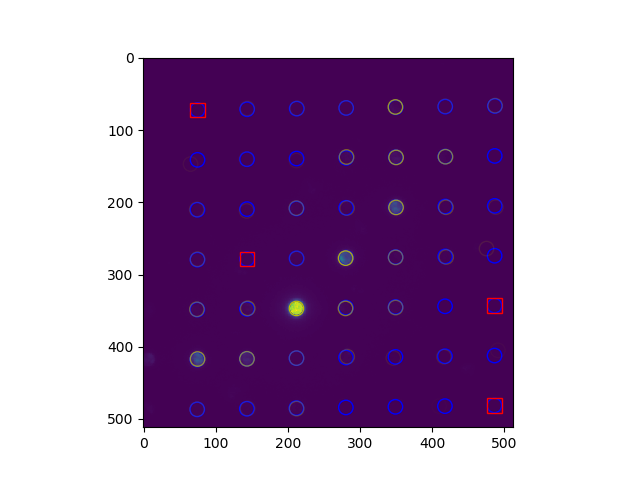

In [12]:
fig, axes = plt.subplots()

pick_y = 16
pick_x = 8

index = (pick_y * x + pick_x)

get_sample_frame = ctx.create_pick_analysis(dataset=ds, y=pick_y, x=pick_x)
sample_frame = ctx.run(get_sample_frame)

axes.imshow(sample_frame[0].raw_data)

sample_refined_fit = match['refineds'].data[index]
sample_elevations = match['peak_elevations'].data[index]
selector = match['selector'].data[index]

max_elevation = np.max(sample_elevations)

calculated = grm.calc_coords(
    zero=match['zero'].data[index],
    a=match['a'].data[index],
    b=match['b'].data[index],
    indices=indices
)

#axes.add_artist(plt.Circle(sample_zero, parameters['radius'], color="b", fill=False))
#for p in sample_fit[1:]:
#    axes.add_artist(plt.Circle(p, parameters['radius'], color="r", fill=False))

for i in range(len(calculated)):
    p = np.flip(calculated[i])
    axes.add_artist(plt.Circle(p, corr_params['radius'], color="b", fill=False))

selected_refined = sample_refined_fit[selector]
selected_elevations = sample_elevations[selector]
    
for i in range(len(selected_refined)):
    p = np.flip(selected_refined[i])
    a = max(0, selected_elevations[i] / max_elevation)
    axes.add_artist(plt.Circle(p, corr_params['radius'], color="y", fill=False, alpha=a))
    
skipped_peaks = calculated[np.invert(selector)]

for i in range(len(skipped_peaks)):
    (yy, xx) = skipped_peaks[i]
    r = corr_params['radius']
    xy = (xx - r, yy - r)
    axes.add_artist(plt.Rectangle(xy, 2*r, 2*r, color="r", fill=False))
